# Predicting Strokes from Admission Data

In this exercise we are going to try to predict strokes from admission data with various models, and learn how to deal with the issue of class imbalance.

Uses the [stroke dataset from Kaggle](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset) along with the `sklearn` and `pandas` packages!

## First Steps
To begin with, let's setup our notebook with the necessary packages as well as grab the data from Kaggle!

In [1]:
# TODO: Establish venv/conda/package environment
# Commands with `%` run in the command line instead of within python so we don't have to do this within a seperate terminal!
# In this case, we are making sure our environment/colab instance has installed the latest versions of several commonly used data science packages
%pip install pandas numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Setup matplotlib to display plots correctly within pandas
%matplotlib inline

# Import packages into our runtime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Download from Kaggle

Those who have downloaded and setup the kaggle CLI (Command Line Interface) can run the following command to download the dataset:

In [3]:
# Download the stroke prediction dataset into the ./data folder
!kaggle datasets download -d fedesoriano/stroke-prediction-dataset --path ./data

stroke-prediction-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


## Data Exploration
Now we have the data downloaded, we need to load this into a dataframe so we can explore it, and perform further analysis.

We can either do this by unzipping the dataset or just loading it directly with pandas:

In [4]:
# No need to unzip the file - we can load the .csv file within directly into a DataFrame (commonly notated as `df`)
df = pd.read_csv("./data/stroke-prediction-dataset.zip")

It is good practice to explore what data we are actually dealing with and get a *feel* for it. We should check for missing data, what data is present, and relevant datatypes!

There are many ways of doing this with `pandas` ([API](https://pandas.pydata.org/docs/reference/frame.html#attributes-and-underlying-data)) - the most useful and commonly used methods being `head()`, `info()`, `describe()` initially:

In [5]:
# Let's have a look at the first 10 entries of the dataset
df.head(10)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
6,53882,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
7,10434,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
9,60491,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [7]:
# Describe is useful for looking at continuous data (i.e. int or float datatypes) - we can see it also has a look at data which is
# stored as booleans, as well as ID's (i.e. the id, hypertension, heart_disease, and stroke coluns)

# We can see
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [8]:
# We can exclude the boolean or ID data by selecting certain rows for example

df[["age", "avg_glucose_level", "bmi"]].describe()

,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,4909.000000
mean,43.226614,106.147677,28.893237
std,22.612647,45.283560,7.854067
min,0.080000,55.120000,10.300000
25%,25.000000,77.245000,23.500000
50%,45.000000,91.885000,28.100000
75%,61.000000,114.090000,33.100000
max,82.000000,271.740000,97.600000


### Correlation and Graphing

We can explore the data further by looking at the correlation of datasets - in this case using a [Pearson correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient), which looks for **linear** correlations between variables (non-linear correlations will not be identified)

In [9]:
corr = df.corr(numeric_only=True)
corr.style.background_gradient(cmap="coolwarm").format(precision=2)

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
id,1.00,0.00,0.00,-0.00,0.00,0.00,0.01
age,0.00,1.00,0.28,0.26,0.24,0.33,0.25
hypertension,0.00,0.28,1.00,0.11,0.17,0.17,0.13
heart_disease,-0.00,0.26,0.11,1.00,0.16,0.04,0.13
avg_glucose_level,0.00,0.24,0.17,0.16,1.00,0.18,0.13
bmi,0.00,0.33,0.17,0.04,0.18,1.00,0.04
stroke,0.01,0.25,0.13,0.13,0.13,0.04,1.00


<AxesSubplot: xlabel='age', ylabel='bmi'>

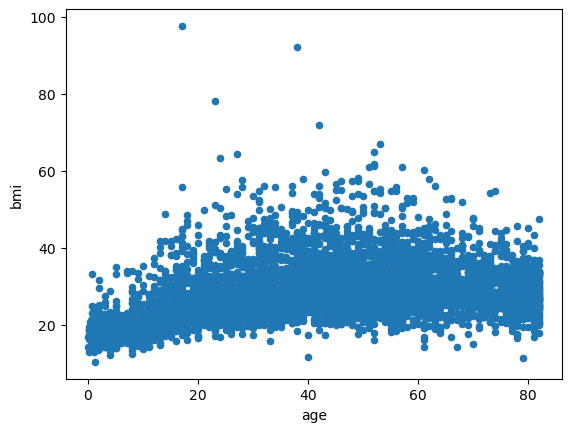

In [10]:
import seaborn as sns

df.plot.scatter(x="age", y="bmi")

In [11]:
df["stroke"].value_counts(normalize=True)

0    0.951272
1    0.048728
Name: stroke, dtype: float64

## Building a Model
Now we have a feel for our dataset, we can begin building a useful model to try and predict outcomes

### Test-Train Split
We need to split our model into training sets (data which the machine learning algorithm uses to learn) and testing sets (used to validate how well our model is working).

### Data Pre-processing
In order to use our data - we will need to convert how our data is stored in order for machine learning models to interpret it. For example `Male` or `Female` can't be correctly interpreted.

Continuous data (i.e. BMI, Average Blood Glucose, and so on) will need to be scaled.


In [12]:
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

We can see we are missing 201 BMI values: at this point we have two options, to either drop the rows which are missing data, or to _impute_ their values. In this case, we will go for the latter!

There are more complex approaches to doing this - which can be done using the [`sklearn` library](https://scikit-learn.org/stable/modules/impute.html)

In [51]:
# First calculate the average
mean_bmi = df["bmi"].mean()

# Now fill missing values with this mean
df["bmi"] = df["bmi"].fillna(mean_bmi)

# Check that our commands have worked!
df.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [105]:
# We can get rid of 'ID' column, this isn't needed!
df = df.drop(columns=["id"])

# We can then develop our `X` and `y` sets
X = df.drop(columns=["stroke"])
y = df["stroke"]

In [108]:
# We can double check we have the right shape of data - we should have 5110 rows, with 10 features in the X set - and only a column of 1 or 0 in the y column
print(X.shape)
print(y.shape)

(5110, 10)
(5110,)


In [107]:
# Perfect! Now to split into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [111]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline

numerical_columns = ["age", "avg_glucose_level", "bmi"]
ordinal_columns = ["work_type"]

In [ ]:
from sklearn.linear_model import LinearRegression

# TODO: Build first models

## Unbalanced Datasets

In [26]:
# TODO: Explain problem with unbalanced datasets
# TODO: Accuracy paradox --> look at alternative, e.g. F1 score, AUC
# TODO: Explore imbalanced-learn package amongst others